In [43]:
import plotly.offline as pox
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [28]:
df = pd.read_csv('amzn_data.csv')
# Filter and remove rows where 'volume' is 0
d = df[df['volume'] == 0]
df = df.drop(d.index, axis=0)

# Convert 'time' to datetime format and extract only the date part
df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.date

# Set the 'time' column as the index
df = df.set_index('time')

# Sort the DataFrame by date
df = df.sort_index(ascending=True)

# Create a copy of the modified DataFrame
next = df.copy()

# Display the tail of the new DataFrame and print "done"
next.tail()

,open,high,low,close,volume
time,,,,,
2024-10-30,194.699997,195.610001,192.419998,192.729996,37707600
2024-10-31,190.509995,190.600006,185.229996,186.399994,75146800
2024-11-01,199.000000,200.500000,197.020004,197.929993,99687800
2024-11-04,196.449997,197.330002,194.309998,195.779999,38492100
2024-11-05,196.039993,199.820007,195.990005,199.500000,30449900


In [29]:
# Calculate future returns and signals
df['future_returns'] = df['close'].pct_change().shift(-1)
signal = []
for i in range(len(df)):
    if df['future_returns'].iloc[i] > 0:
        signal.append(1)
    elif df['future_returns'].iloc[i] < 0:
        signal.append(2)
    else:
        signal.append(3)

df['signal'] = signal

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = calculate_rsi(df['close'], 14)

# Calculate ADX
def calculate_adx(df, period=50):
    high = df['high']
    low = df['low']
    close = df['close']

    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = true_range.rolling(window=period).mean()

    plus_di = 100 * (plus_dm.rolling(window=period).mean() / atr)
    minus_di = 100 * (minus_dm.abs().rolling(window=period).mean() / atr)

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period).mean()
    return adx

df['adx'] = calculate_adx(df, 50)

# Calculate NATR
def calculate_natr(df, period=50):
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = true_range.rolling(window=period).mean()
    natr = (atr / df['close']) * 100
    return natr

df['NATR'] = calculate_natr(df, 50)

# Calculate SMA
df['sma'] = df['close'].rolling(window=30).mean()

# Calculate correlation
df['corr'] = df['close'].rolling(window=int(6.5 * 4)).corr(df['sma'])

# Other features
df['Open-Close'] = (df['open'] - df['close']).shift(-1)
df['Close-High'] = (df['close'] - df['high']).shift(-1)
df['Close-Low'] = (df['close'] - df['low']).shift(-1)

# Drop NaN values
df.dropna(inplace=True)

# Define target and features
y = df[['signal']].copy()
X = df[['rsi', 'adx', 'corr', 'sma', 'NATR', 'volume', 'Open-Close', 'Close-Low', 'Close-High']].copy()

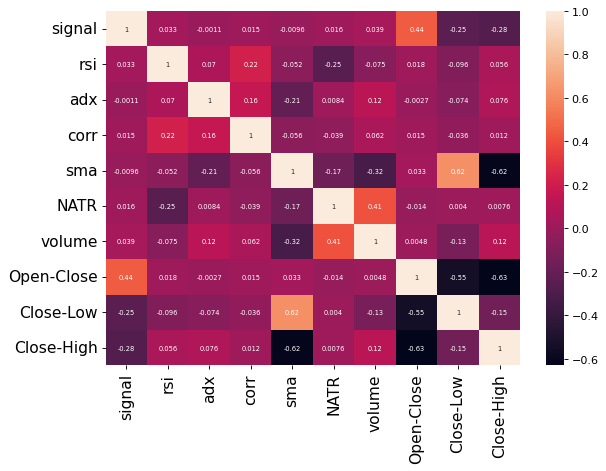

In [30]:
z=df[['signal', 'rsi', 'adx', 'corr', 'sma', 'NATR', 'volume', 'Open-Close', 'Close-Low', 'Close-High']].copy()
corr = z.corr()
figure(figsize=(8, 6), dpi=80)
sns.heatmap(corr, annot=True, annot_kws = {"size": 6})
plt.yticks(rotation=0, size = 14);
plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

In [31]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns

    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index


print(get_pair_above_threshold(X, 0.7))

MultiIndex([], )


In [32]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """
    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'
# Check for stationarity
for col in X.columns:
    if stationary(df[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

rsi is stationary.
adx is stationary.
corr is stationary.
sma is not stationary. Dropping it.
NATR is stationary.
volume is stationary.
Open-Close is stationary.
Close-Low is not stationary. Dropping it.
Close-High is stationary.


In [52]:
# Encode target variable if necessary
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Converts categories to integers

# Split data
split_percentage = 0.7
split = int(split_percentage * len(df))

X_train = X[:split]
y_train = y_encoded[:split]
X_test = X[split:]
y_test = y_encoded[split:]

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

# Prepare LightGBM dataset
train_data = lgb.Dataset(X_train_scaled, label=y_train, weight=[class_weights_dict[i] for i in y_train])

# Define parameters
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbosity': -1
}

# Train the model
num_round = 100
model = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[train_data]
)

# Predict
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# Decode labels
y_pred_decoded = le.inverse_transform(y_pred)
y_test_decoded = le.inverse_transform(y_test)

# Accuracy
Accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {Accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Class Weights: {0: 0.6404166666666666, 1: 0.6984776187230175, 2: 146.38095238095238}
Model Accuracy: 0.82


In [53]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       686
           1       0.80      0.85      0.82       629
           2       0.00      0.00      0.00         3

    accuracy                           0.82      1318
   macro avg       0.55      0.55      0.55      1318
weighted avg       0.82      0.82      0.82      1318



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [54]:
Prediction = model.predict(X)[-1]  # Get the prediction for the last sample
predicted_class = np.argmax(Prediction)  # Get the class with the highest probability

if predicted_class == 1:
    print('Buy')
elif predicted_class == 2:
    print('Sell')
else:
    print('Hold')
print(predicted_class)  # Print the predicted class index

Hold
0


In [55]:
split_percentage = 0.7
split = int(split_percentage*len(df))
temp=pd.DataFrame()
temp['close'] = df.close.iloc[split:]
temp['signal']=np.array(y_pred)
temp.tail()

,close,signal
time,,
2024-10-29,190.830002,1
2024-10-30,192.729996,1
2024-10-31,186.399994,1
2024-11-01,197.929993,1
2024-11-04,195.779999,0


In [56]:
# Variable Required for decision making
buy=[]
sell=[]
profit=[]
Close_profit=[]
Stop_loss=[]
Close_order_buy=[]
Close_order_sell=[]
position_Buy=None
position_Sell=None
profit=0.4
lose=0.4

#Decision Making Process

In [57]:
for i in range(len(temp)):
   #####################################################################################################
    if position_Buy!="Buy"  and position_Sell!="Sell" and Accuracy >0.50 and temp['signal'][i]== 1 :                          #Buy Position
                    buy.append(temp['close'][i])
                    sell.append(np.nan)
                    Close_profit.append(np.nan)
                    Stop_loss.append(np.nan)
                    Close_order_buy.append(temp['close'][i])
                    position_Buy="Buy"
    #############################################################################################
    elif  position_Sell!="Sell"  and position_Buy!="Buy" and Accuracy >0.50 and temp['signal'][i]== 2   :                     #Sell Position
                sell.append(temp['close'][i])
                buy.append(np.nan)
                Close_profit.append(np.nan)
                Stop_loss.append(np.nan)
                Close_order_sell.append(temp['close'][i])
                position_Sell="Sell"

    #################################################################################################
    elif position_Sell=="Sell" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_sell[-1]+lose) <= temp['close'][i]):                   #Take Profit Condition
            Close_profit.append(np.nan)                                        #append to take profit
            Stop_loss.append(temp['close'][i])
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        elif ((Close_order_sell[-1]-(profit)) >= temp['close'][i]):                   #Stop Loss Condition
            Close_profit.append(temp['close'][i])
            Stop_loss.append(np.nan)                                                #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
    ########################################################################################################
    elif position_Buy=="Buy" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_buy[-1]+profit) <= temp['close'][i]):                  #Take Profit Condition
            Close_profit.append(temp['close'][i])                          #append to take profit
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
            position_Buy=None

        elif ((Close_order_buy[-1]-lose) >= temp['close'][i]):                   #Stop Loss Condition
            Close_profit.append(np.nan)
            Stop_loss.append(temp['close'][i])                                  #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            position_Buy=None

        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
#################################################################
    else:
            buy.append(np.nan)
            sell.append(np.nan)
            Stop_loss.append(np.nan)
            Close_profit.append(np.nan)
temp['buy']=buy
temp['sell']=sell
temp['Close_profit']=Close_profit
temp['Stop_loss']=Stop_loss
print((temp[temp['buy']!=np.nan]).count())
print(f"Profitibily { temp['Close_profit'].count()/(temp['Close_profit'].count()+temp['Stop_loss'].count())}")

close           1318
signal          1318
buy              411
sell               0
Close_profit      86
Stop_loss        325
dtype: int64
Profitibily 0.20924574209245742


<ipython-input-57-708f1d65bd04>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-57-708f1d65bd04>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-57-708f1d65bd04>:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-57-708f1d65bd04>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent w

In [58]:
# Simulate trading based on the model's predictions to evaluate profitability

# Initialize simulation parameters
initial_capital = 10000  # Starting capital in USD
commission = 0.001  # 0.1% commission fee per trade
cash = initial_capital  # Cash available
shares = 0  # Shares held
portfolio_value = [initial_capital]  # Portfolio value over time

# Iterate over the test set to simulate trades
for i in range(len(X_test)):
    signal = y_pred[i]
    price = df['close'].iloc[split + i]  # Corresponding close price in the test set

    if signal == 1:  # Buy signal
        if cash >= price:  # Only buy if sufficient cash is available
            cash -= price * (1 + commission)
            shares += 1
    elif signal == 2:  # Sell signal
        if shares > 0:  # Only sell if shares are held
            cash += price * (1 - commission)
            shares -= 1

    # Calculate portfolio value
    portfolio_value.append(cash + shares * price)

# Calculate profitability metrics
final_portfolio_value = portfolio_value[-1]
profit = final_portfolio_value - initial_capital
profit_percentage = (profit / initial_capital) * 100

# Display results
profit, profit_percentage, final_portfolio_value


(9971.488777030943, 99.71488777030943, 19971.488777030943)

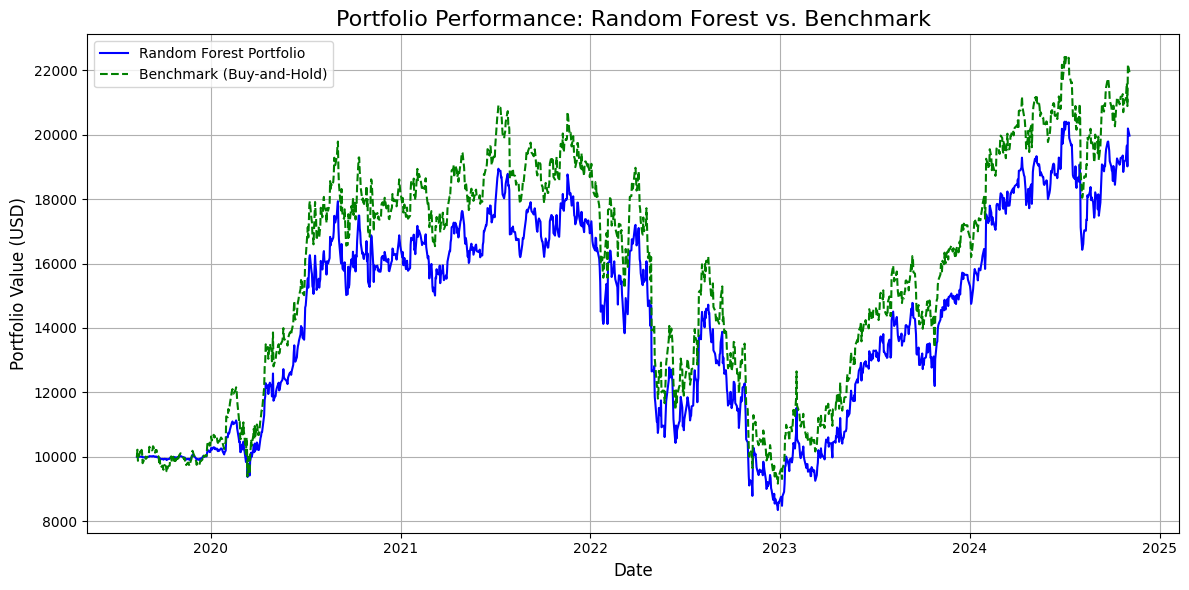

(11937.116953043227, 119.37116953043227, 21937.116953043227)

In [59]:
# Simulate the benchmark (buy-and-hold strategy)
benchmark_shares = initial_capital / df['close'].iloc[split]  # Buy shares at the start of the test period
benchmark_value = [
    benchmark_shares * df['close'].iloc[split + i] for i in range(len(X_test))
]

# Visualize portfolio growth compared to the benchmark
import matplotlib.pyplot as plt

# Time indices for the test set
test_dates = df.index[split:split + len(X_test)]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_dates, portfolio_value[1:], label='Random Forest Portfolio', color='blue')
plt.plot(test_dates, benchmark_value, label='Benchmark (Buy-and-Hold)', color='green', linestyle='--')
plt.title('Portfolio Performance: Random Forest vs. Benchmark', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate benchmark profitability
benchmark_final_value = benchmark_value[-1]
benchmark_profit = benchmark_final_value - initial_capital
benchmark_profit_percentage = (benchmark_profit / initial_capital) * 100

# Display benchmark results
benchmark_profit, benchmark_profit_percentage, benchmark_final_value


In [60]:
import numpy as np

# Calculate cumulative return (%)
cumulative_return = (portfolio_value[-1] / portfolio_value[0] - 1) * 100

# Calculate annual return (%)
num_years = len(test_dates) / 252  # Assuming 252 trading days in a year
annual_return = ((portfolio_value[-1] / portfolio_value[0]) ** (1 / num_years) - 1) * 100

# Calculate maximum drawdown (%)
cumulative_max = np.maximum.accumulate(portfolio_value)
drawdown = (portfolio_value - cumulative_max) / cumulative_max
max_drawdown = drawdown.min() * 100

# Calculate Sharpe ratio
daily_returns = np.diff(portfolio_value) / portfolio_value[:-1]
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)

# Ending capital
ending_capital = portfolio_value[-1]

# Results
print(f"Cumulative Return (%): {cumulative_return:.2f}")
print(f"Annual Return (%): {annual_return:.2f}")
print(f"Maximum Drawdown (%): {max_drawdown:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Ending Capital: ${ending_capital:.2f}")

Cumulative Return (%): 99.71
Annual Return (%): 14.14
Maximum Drawdown (%): -55.93
Sharpe Ratio: 0.56
Ending Capital: $19971.49


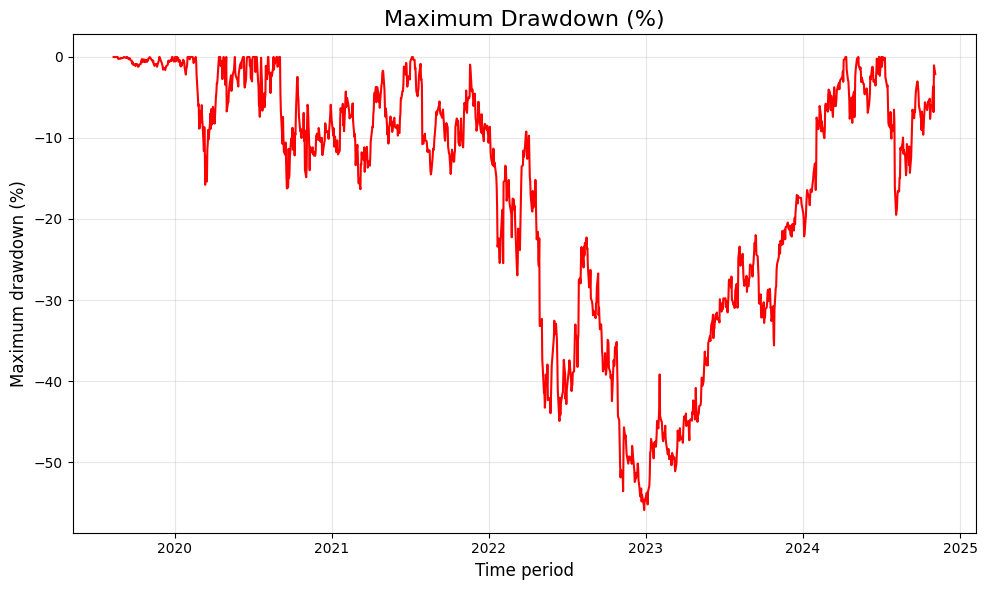

In [61]:
# Correct drawdown calculation to match test_dates length
cumulative_max = np.maximum.accumulate(portfolio_value[1:])  # Exclude the first value for alignment
drawdown = (portfolio_value[1:] - cumulative_max) / cumulative_max * 100

# Plotting the maximum drawdown graph
plt.figure(figsize=(10, 6))
plt.plot(test_dates, drawdown, color='red')
plt.title("Maximum Drawdown (%)", fontsize=16)
plt.xlabel("Time period", fontsize=12)
plt.ylabel("Maximum drawdown (%)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
symb = company_dict[target_company] + " RF + XGBOOST"
# trace1=go.Candlestick(
# x=df.index,
# low=df['low'],
# close=df['close'],
# open=df['open'],
# high=df['high'],
# increasing_line_color='green',
# decreasing_line_color='red',
# name='USD/EUR',
# )
trace1=go.Scatter(
    y=temp.close,
    mode='lines',
    name='Close_price'
)

trace4=go.Scatter(

    y=temp['buy'],
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='triangle-up' ),
    name='buy'
    )
trace5=go.Scatter(

    y=temp.sell,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='triangle-down'),
    name='sell')
trace6=go.Scatter(

    y=temp.Close_profit,
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='cross'),
    name='Profit')
trace7=go.Scatter(

    y=temp.Stop_loss,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='cross'),
    name='Loss')

data=[trace1,trace4,trace5,trace6,trace7]
layout=go.Layout(
    title=symb,
    yaxis=dict(title='Assest value'),
    xaxis=dict(title='Days'))
figure=go.Figure(data=data,layout=layout)
figure.update_layout(xaxis_rangeslider_visible=False)
pox.plot(figure)